## Haystack Example
---

Haystack is an AI orchestration framework to build customizable, production-ready LLM applications. Connect components (models, vector DBs, file converters) to pipelines or agents that can interact with your data. With advanced retrieval methods, it's best suited for building RAG, question answering, semantic search or conversational agent chatbots.

Haystack provides [pipelines](https://docs.haystack.deepset.ai/docs/pipelines) and Agents, two powerful structures for designing LLM applications for various use cases including search, question answering, and conversational AI. With a big focus on state-of-the art retrieval methods and solid evaluation metrics, it provides you with everything you need to ship a reliable, trustworthy application. You can serialize pipelines to YAML files, expose them via a REST API, and scale them flexibly with your workloads, making it easy to move your application from a prototype stage to production.

### Haystack Basics:
---

Haystack is built on the concept of two main architectures: Components + Pipelines. We create pipelines by combining the components needed for our application.

![Pipeline structure](AWS_Haystack_Examples/images/pipeline_structure.png)

Pipelines are structures created by components - this can be a RAG application, A simple application to store embeddings to a vector store, etc. We attach the components structure together to create a pipeline.

A pipeline can do two things: Branching + Looping.

#### What are components?

Components are a certain entity that expects an input and produces a certain number of outputs (this is at the flexibility of the user). Haystack provides some components options: Generators, embedders, doc pre-processors. You can build your own component as well.

You can also start attaching components to each other as given below if the output and input type match. The first component takes a string and produces an embedding (which is an Embedder) and the next component is a retriever which takes in embeddings and generates a document from it.

![Component structure](AWS_Haystack_Examples/images/components.png)

### Classic RAG pipeline

![RAG pipeline structure](AWS_Haystack_Examples/images/rag_pipeline.png)

Here, we have 4 components: an embeddor, a retriever to return documents, a prompt builder, and a generator. There are several component types that are supported. 

#### You can build your own component

``` {.python}
from typing import List
from haystack import component

@component
class Translator:
    
    # define the output type of the component
    # this is used for pipeline validation down the line
    @component.output_types(documents=List[Document])
    def run(self, 
            from_lang: str = 'en', 
            to_lang: str = 'fr', 
            documents:List[Document]):
        translated_documents = []
        # translate documents from_lang to to_lang and add
        # them to the translated_documents
        return {"documents": translated_documents}
```

For more information on Haystack, view the documentation on Haystack pipelines and components [here](https://docs.haystack.deepset.ai/docs/pipelines#yaml-file-definitions).

### Creating Pipelines: Simple RAG application
--- 

In this portion of the notebook, we will create a simple RAG application pipeline using Haystack components.

In [1]:
# For each component, it is essential to know the names of the input and the output. There are several components for various steps
# of the generative AI pipeline that are provided out of the box. This includes components for document stores, embedders, prompt
# builders and generators. You can also build your own component.
!pip install -U pip
!pip install -U haystack
!pip install -U sentence-transformers

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [2]:
# import dependencies
import logging
from haystack import Pipeline

# Set a logger
logging.basicConfig(format='[%(asctime)s] p%(process)s {%(filename)s:%(lineno)d} %(levelname)s - %(message)s', level=logging.INFO)
logger = logging.getLogger(__name__)

# initialize a haystack pipeline
pipeline = Pipeline()

/opt/homebrew/anaconda3/lib/python3.11/site-packages/haystack/core/errors.py:34: DeprecationWarning: PipelineMaxLoops is deprecated and will be remove in version '2.7.0'; use PipelineMaxComponentRuns instead.
  warnings.warn(


In [3]:
# import the in memory document store 
from haystack.document_stores.in_memory import InMemoryDocumentStore

# initialize the document store
document_store = InMemoryDocumentStore()

In [4]:
# initialize the embedders and writers as a part of the RAG pipeline
from haystack.components.writers import DocumentWriter
from haystack.components.embedders import SentenceTransformersDocumentEmbedder

# Now, let's add the embedder and writer components to the RAG pipeline.
# The sentence transformer document embedder uses the 'all-mpnet-base-v2' model as default
pipeline.add_component('embedder', SentenceTransformersDocumentEmbedder())
# whenever we use a document writer it writes document to the document store
pipeline.add_component('writer', DocumentWriter(document_store))

# once we have added the embedder and writer components, we can connect them to the RAG pipeline.
pipeline.connect('embedder', 'writer')

🚅 Components
  - embedder: SentenceTransformersDocumentEmbedder
  - writer: DocumentWriter
🛤️ Connections
  - embedder.documents -> writer.documents (List[Document])

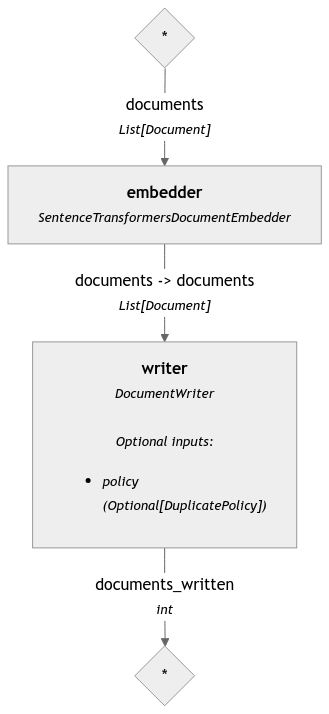

In [5]:
# Now we can do Pipeline.show() to view all of the components that are a part of our RAG
# application
pipeline.show()

Now, we can see that there are no documents in the `pipeline.show()` above. This is useful when building complex pipelines doing branching and looping. 

Embedder expects documents so let's add some documents:

In [6]:
from haystack.dataclasses import Document

# Create synthetic data
synthetic_data = [
    "Amazon Web Services (AWS) is a comprehensive cloud computing platform.",
    "AWS offers a wide range of services including compute, storage, and machine learning.",
    "Elastic Compute Cloud (EC2) is a web service that provides resizable compute capacity in the cloud.",
    "Amazon S3 is an object storage service offering industry-leading scalability and data availability.",
    "AWS Lambda lets you run code without provisioning or managing servers."
]

# Now let's add the documents with synthetic data to our index and run the pipeline
pipeline.run({
    "embedder": {
        "documents": [
            Document(content=data) for data in synthetic_data
        ]
    }
})

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

{'writer': {'documents_written': 5}}

In [7]:
# Once the docs are written to the document store, we can filter to view the documents that are loaded, 
# along with vector representations of the documents
document_store.filter_documents()

[Document(id=46761d097feb256e97645a64f3c90a2996aae348dcd479ada5ece60dce965b74, content: 'Amazon Web Services (AWS) is a comprehensive cloud computing platform.', embedding: vector of size 768),
 Document(id=db8dcb9c4353f4d5e6f969f0a56a9d4d6365afc417dbb2bd6699aaa9bdc703ee, content: 'AWS offers a wide range of services including compute, storage, and machine learning.', embedding: vector of size 768),
 Document(id=517f1685dd26674db61cbdeaf01b3c385f0862c33eeaa86a3eb9bec678b56349, content: 'Elastic Compute Cloud (EC2) is a web service that provides resizable compute capacity in the cloud.', embedding: vector of size 768),
 Document(id=261646794e149651c2b53065db77a6c5611612de4ce12374e4bb78383a061c81, content: 'Amazon S3 is an object storage service offering industry-leading scalability and data availability.', embedding: vector of size 768),
 Document(id=2c36da493e0d66835d486146d64e238c417a7f510599469e0977534ded3ee543, content: 'AWS Lambda lets you run code without provisioning or managing 

### Build a RAG Pipeline using Amazon Bedrock
---

In this portion of the notebook, we build a RAG pipeline with other components. These include the prompt builder, the SentenceTransformersTextEmbedder, the InMemoryEmbeddingRetriever since we have already ingested documents in the document store and a `BedrockGenerator` to generate responses. There are several components that are provided as options, you can build your own component too.

In [8]:
# Define the region
AWS_REGION: str = "us-west-2"
BEDROCK_HAIKU_MODELID: str = "anthropic.claude-3-haiku-20240307-v1:0"
SONNET_3_5_MODELID: str = "anthropic.claude-3-5-sonnet-20240620-v1:0"
TITAN_TEXT_EMBED_MODELID: str = "amazon.titan-embed-text-v2:0"

In [9]:
!pip install -Uq amazon-bedrock-haystack

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [10]:
# Import necessary modules
from haystack.components.builders import PromptBuilder
# In this case, we use the bedrock generator to generate responses based on the question and the prompt
from haystack.components.embedders import SentenceTransformersTextEmbedder
from haystack.components.retrievers.in_memory import InMemoryEmbeddingRetriever
from haystack_integrations.components.generators.amazon_bedrock import AmazonBedrockGenerator

# initialize the embdder
embedder = SentenceTransformersTextEmbedder()

# initialize the retriever
retriever = InMemoryEmbeddingRetriever(document_store=document_store)

# Build the prompt template. In haystack prompt template is all done with jinja templating
prompt_template = """Given the following context, answer the question. Follow the instructions below
while answering the question given in the <instructions></instructions> xml tags:

<instructions>
- Answer the question in a clear and concise manner.
- If the answer is not in the context, say "I don't know"
</instructions>

Context:
{% for document in documents %}
    {{ document.content }}
{% endfor %}

Question: {{ question }}
"""

In [11]:
prompt_builder = PromptBuilder(template=prompt_template)
# initialize the generator
generator = AmazonBedrockGenerator(model=SONNET_3_5_MODELID)

#### Construct the RAG pipeline
---

Now that we have defined the prompt template, the generator, let's construct the RAG pipeline by adding these components and connecting each component based on relevant inputs and outputs.

In [12]:
bedrock_rag_pipeline = Pipeline()
bedrock_rag_pipeline.add_component('embedder', embedder)
bedrock_rag_pipeline.add_component('retriever', retriever)
bedrock_rag_pipeline.add_component('prompt_builder', prompt_builder)
bedrock_rag_pipeline.add_component('generator', generator)

# next, connect each of these componennts in the pipeline
bedrock_rag_pipeline.connect('embedder', 'retriever')
# you can also connect specific portions of the components with one another as follows
# In this case, the retriever are outputting documents so we explicitly mention that
bedrock_rag_pipeline.connect('retriever.documents', 'prompt_builder.documents')
bedrock_rag_pipeline.connect('prompt_builder', 'generator')

🚅 Components
  - embedder: SentenceTransformersTextEmbedder
  - retriever: InMemoryEmbeddingRetriever
  - prompt_builder: PromptBuilder
  - generator: AmazonBedrockGenerator
🛤️ Connections
  - embedder.embedding -> retriever.query_embedding (List[float])
  - retriever.documents -> prompt_builder.documents (List[Document])
  - prompt_builder.prompt -> generator.prompt (str)

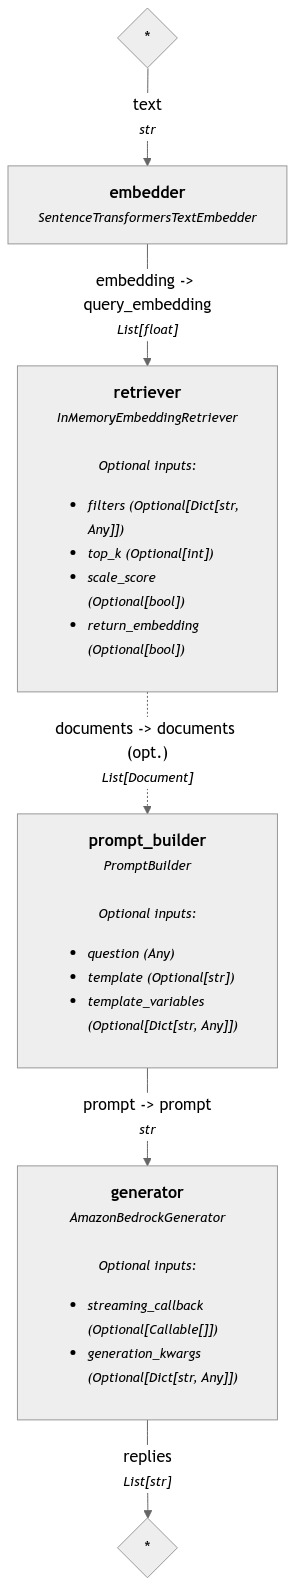

In [13]:
bedrock_rag_pipeline.show()

In [14]:
# run the pipeline and ask a question
question: str = "What is Amazon Elastic Compute Cloud (EC2)?"
generator_response = bedrock_rag_pipeline.run({"embedder": {"text": question}, 
                          "prompt_builder": {"question": question}})

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [21]:
generator_response['generator']['replies'][0]

'Elastic Compute Cloud (EC2) is a web service that provides resizable compute capacity in the cloud.'